## Workflow for processing data coming from OT2 
- 2025/03/18 Runze
- Deposition: OCV --> CP --> OCV
- Characterization: CV --> PEIS --> LP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import autoeis as ae
import arviz as az
import seaborn as sns


### Specify the experiments


In [4]:
# batch 3 20250312-20250314 (repeated batch 1)

file_path = "/home/runzezhang/Data/OT2/20250314_substrate test"
substrate_dict = {
    "MGL_front1": "20250312_000", "MGL_front2": "20250313_001", "MGL_front3": "20250314_002",
    "MGL_back1": "20250314_003", "MGL_back2": "20250314_004", "MGL_back3": "20250314_005",
    "398b_front1": "20250314_006", "398b_front2": "20250314_007", "398b_front3": "20250314_008",
    "398b_back1": "20250314_009", "398b_back2": "20250314_010", "398b_back3": "20250314_011",
    "590937_front1": "20250314_012", "590937_front2": "20250314_013", "590937_front3": "20250314_014"
}


### Load the data

In [ ]:
substrate_id = "MGL_front1"

In [53]:
# load deposition folder

deposition_folder = file_path + f"/{substrate_dict[substrate_id]}" +"/deposition"
characterization_folder = file_path + f"/{substrate_dict[substrate_id]}" +"/characterization"

# load deposition data
dep_files = os.listdir(deposition_folder)
charc_files = os.listdir(characterization_folder)

# Filter files based on the measurement type and ensure they end with '.mpr'
dep_ocv0_path = [f for f in dep_files if "_0_ocv" in f and f.endswith('.csv')]
dep_cp1_path = [f for f in dep_files if "_1_cp" in f and f.endswith('.csv')]
dep_ocv2_path = [f for f in dep_files if "_2_ocv" in f and f.endswith('.csv')]

chara_cv0_path = [f for f in charc_files if "_0_cv" in f and f.endswith('.csv')]
chara_peis1_path = [f for f in charc_files if "_1_peis" in f and f.endswith('.csv')]
chara_lp2_path = [f for f in charc_files if "_2_lp" in f and f.endswith('.csv')]
chara_lp3_path = [f for f in charc_files if "_3_lp" in f and f.endswith('.csv')]

# Load data
dep_ocv0 = pd.read_csv(deposition_folder + '/' + dep_ocv0_path[0])
dep_cp1 = pd.read_csv(deposition_folder + '/' + dep_cp1_path[0])
dep_ocv2 = pd.read_csv(deposition_folder + '/' + dep_ocv2_path[0])

chara_cv0 = pd.read_csv(characterization_folder + '/' + chara_cv0_path[0])
chara_peis1 = pd.read_csv(characterization_folder + '/' + chara_peis1_path[0])
chara_lp2 = pd.read_csv(characterization_folder + '/' + chara_lp2_path[0])
chara_lp3 = pd.read_csv(characterization_folder + '/' + chara_lp3_path[0])

In [ ]:
# Create figure directories if they don’t exist
deposition_fig_folder = os.path.join(deposition_folder, "figures")
characterization_fig_folder = os.path.join(characterization_folder, "figures")

os.makedirs(deposition_fig_folder, exist_ok=True)
os.makedirs(characterization_fig_folder, exist_ok=True)

### Define functions to process different kind of measurements

In [44]:

# Function to save figures (optional)
def save_plot(fig, filename, folder, save=True):
    if save:
        file_path = os.path.join(folder, filename)
        fig.savefig(file_path, dpi=300, bbox_inches='tight')
        plt.close(fig)  # Close the figure to free memory

# Define plotting functions with optional saving
def plot_ocv(data, title, filename, folder, save=True, label=substrate_dict[substrate_id]):
    fig, ax = plt.subplots()
    ax.plot(data['total_time'], data['Ewe'], label=label)
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Potential (V)')
    ax.legend()
    save_plot(fig, filename, folder, save)

def plot_cp(data, title, filename, folder, save=True, label=substrate_dict[substrate_id]):
    fig, ax = plt.subplots()
    ax.plot(data['total_time'], data['Ewe'], label=label)
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Potential (V)')
    ax.legend()
    save_plot(fig, filename, folder, save)

def plot_cv(data, title, filename, folder, save=True, label=substrate_dict[substrate_id]):
    fig, ax = plt.subplots()
    ax.plot(data['Ewe_avg'], data['I_avg'], label=label)
    ax.set_title(title)
    ax.set_xlabel('Potential (V)')
    ax.set_ylabel('Current (A)')
    ax.legend()
    save_plot(fig, filename, folder, save)

def plot_peis(data, title, filename, folder, save=True, label=substrate_dict[substrate_id]):
    def impedance_convert(data):
        data['Zmodulus'] = data['Ewe_mod'] / data['I_mod']
        # data['Zmodulus'] = data['Ewe'] / data['I']
        data['Zreal'] = np.cos(data['phase_Zwe']) * data['Zmodulus']
        data['Zimag'] = np.sin(data['phase_Zwe']) * data['Zmodulus']
        return data

    data = impedance_convert(data)

    fig, ax = plt.subplots()
    ax.plot(data['Zreal'], -data['Zimag'], label=label,marker='o')
    ax.set_title(title)
    ax.set_xlabel('Zreal')
    ax.set_ylabel('-Zimag')
    ax.legend()
    save_plot(fig, filename, folder, save)

def plot_lp(data, title, filename, folder, save=True, label=substrate_dict[substrate_id]):
    fig, ax = plt.subplots()
    ax.plot(data['Ewe_avg'], data['I_avg'], label=label)
    ax.set_title(title)
    ax.set_xlabel('Potential (V)')
    ax.set_ylabel('Current (A)')
    ax.legend()
    save_plot(fig, filename, folder, save)

# Function to combine deposition plots
def plot_combined_deposition(dep_ocv0, dep_cp1, dep_ocv2, title, filename, folder, save=True, label=substrate_dict[substrate_id]):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 plots side by side

    # OCV Plot
    axes[0].plot(dep_ocv0['total_time'], dep_ocv0['Ewe'], label= label)
    axes[0].set_title("Deposition OCV 0")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Potential (V)")
    axes[0].legend()

    # CP Plot
    axes[1].plot(dep_cp1['total_time'], dep_cp1['Ewe'], label=label)
    axes[1].set_title("Deposition CP 1")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Potential (V)")
    axes[1].legend()

    # OCV 2 Plot
    axes[2].plot(dep_ocv2['total_time'], dep_ocv2['Ewe'], label=label)
    axes[2].set_title("Deposition OCV 2")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Potential (V)")
    axes[2].legend()

    plt.tight_layout()
    save_plot(fig, filename, folder, save)

# Function to combine characterization plots
def plot_combined_characterization(chara_cv0, chara_peis1, chara_lp3, title, filename, folder, save=True, label=substrate_dict[substrate_id]):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 plots side by side

    # CV Plot
    axes[0].plot(chara_cv0['Ewe_avg'], chara_cv0['I_avg'], label=label)
    axes[0].set_title("Characterization CV 0")
    axes[0].set_xlabel("Potential (V)")
    axes[0].set_ylabel("Current (A)")
    axes[0].legend()

    # PEIS Plot (Nyquist)
    def impedance_convert(data):
        data['Zmodulus'] = data['Ewe_mod'] / data['I_mod']
        data['Zreal'] = np.cos(data['phase_Zwe']) * data['Zmodulus']
        data['Zimag'] = np.sin(data['phase_Zwe']) * data['Zmodulus']
        return data
    chara_peis1 = impedance_convert(chara_peis1)

    axes[1].plot(chara_peis1['Zreal'], -chara_peis1['Zimag'], label=label)
    axes[1].set_title("Characterization PEIS 1")
    axes[1].set_xlabel("Zreal")
    axes[1].set_ylabel("-Zimag")
    axes[1].legend()

    # LP Plot
    axes[2].plot(chara_lp3['Ewe_avg'], chara_lp3['I_avg'], label= label)
    axes[2].set_title("Characterization LP 2")
    axes[2].set_xlabel("Potential (V)")
    axes[2].set_ylabel("Current (A)")
    axes[2].legend()
    
    plt.tight_layout()
    save_plot(fig, filename, folder, save)

### Define the plot formats

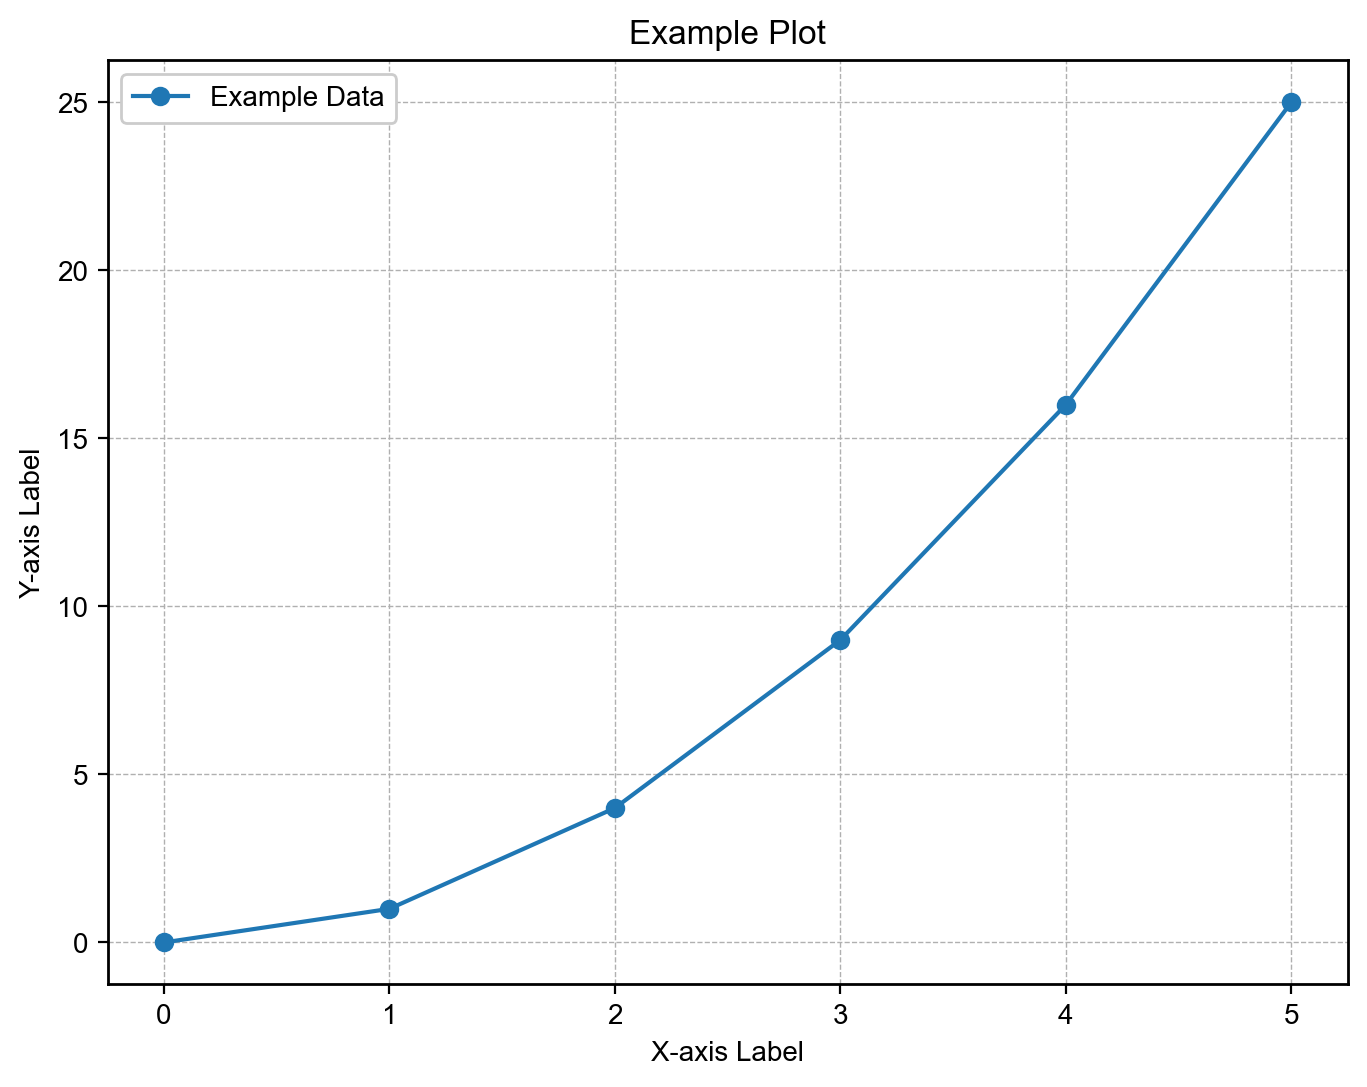

In [15]:
import matplotlib.pyplot as plt

# Set the font size and style
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'Arial',
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 12
})

# Set the figure size
plt.rcParams['figure.figsize'] = [8,6]  # width, height in inches

# Set the line width and marker size
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 6

# Set the axes properties
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5

# Set the legend properties
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.fancybox'] = True
plt.rcParams['legend.loc'] = 'best'

# Set the savefig properties
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.bbox'] = 'tight'

# Example plot to demonstrate the style
x = [0, 1, 2, 3, 4, 5]
y = [0, 1, 4, 9, 16, 25]
plt.plot(x, y, marker='o', label='Example Data')
plt.title('Example Plot')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()
plt.show()


### Make the plots

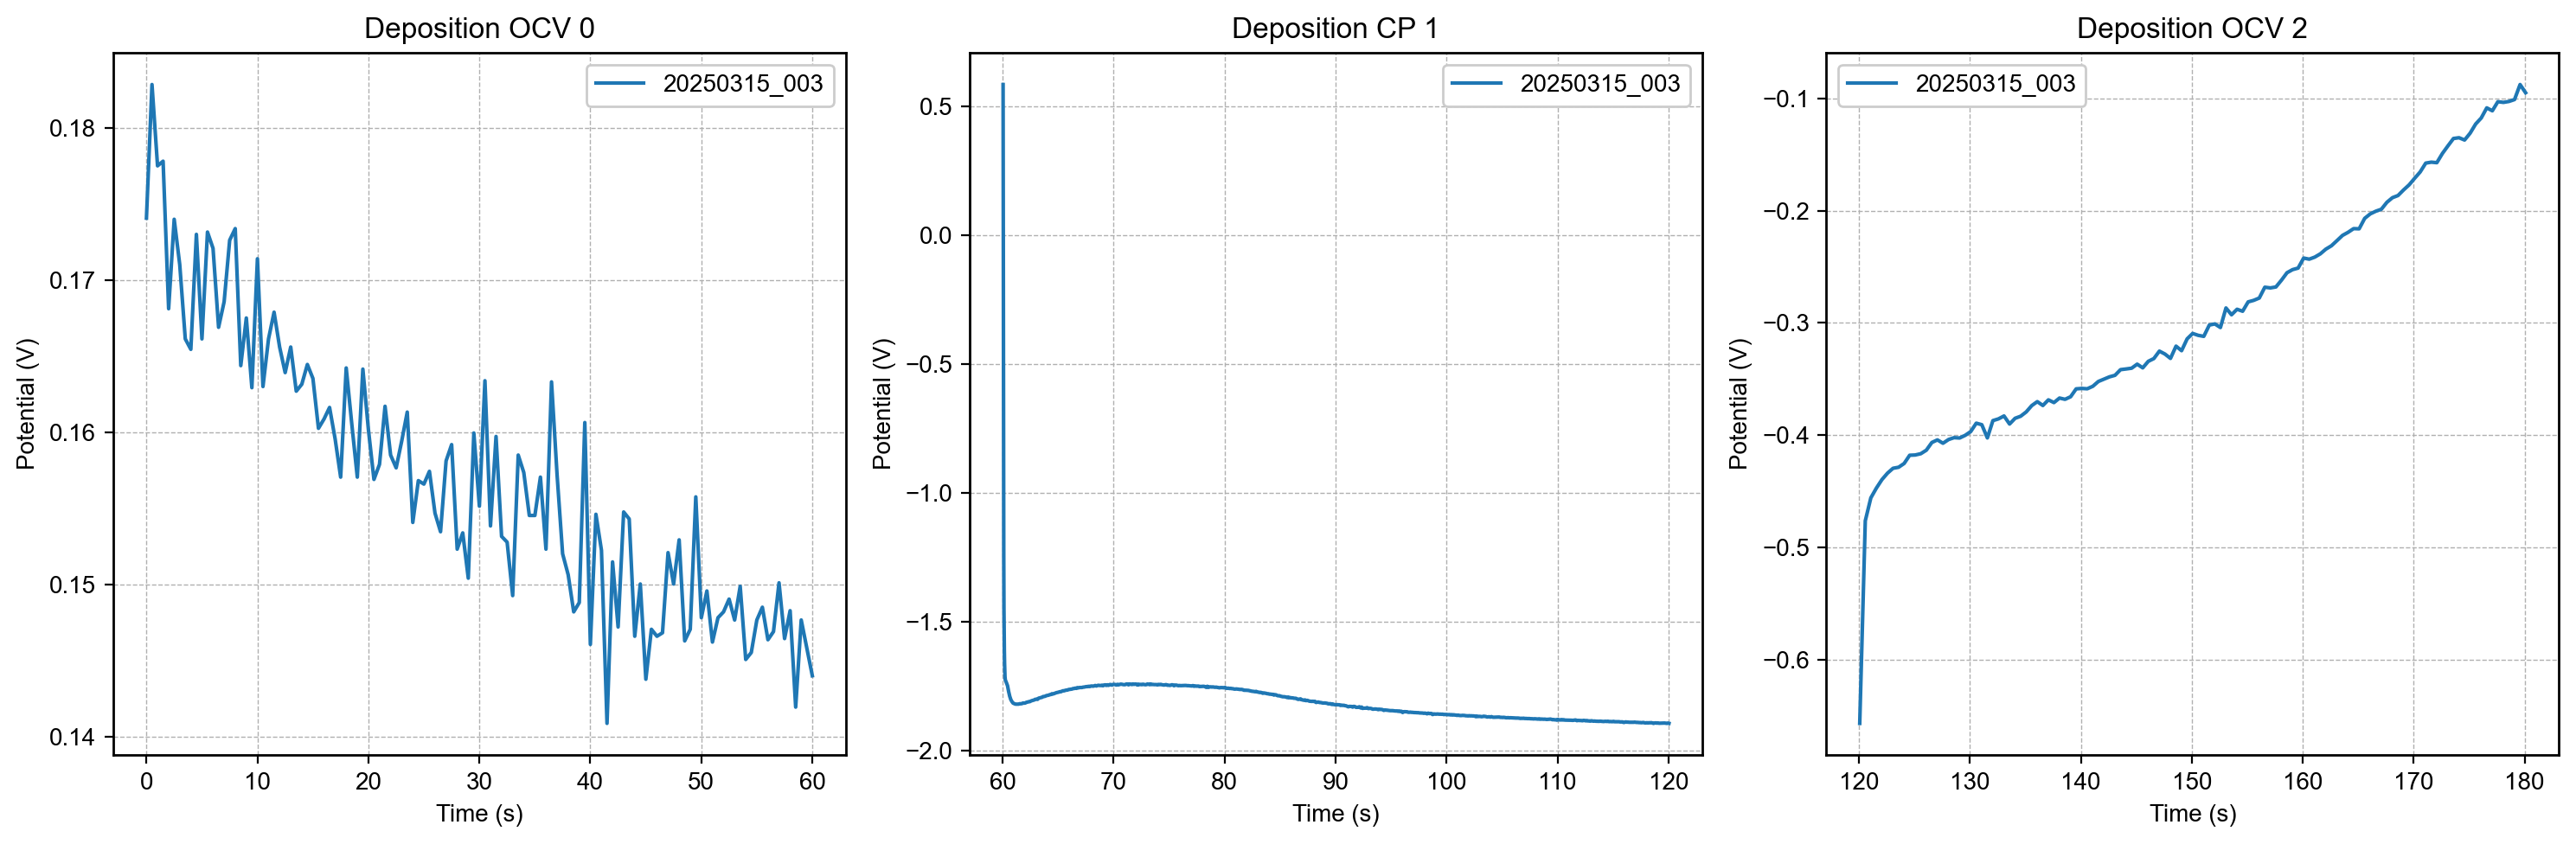

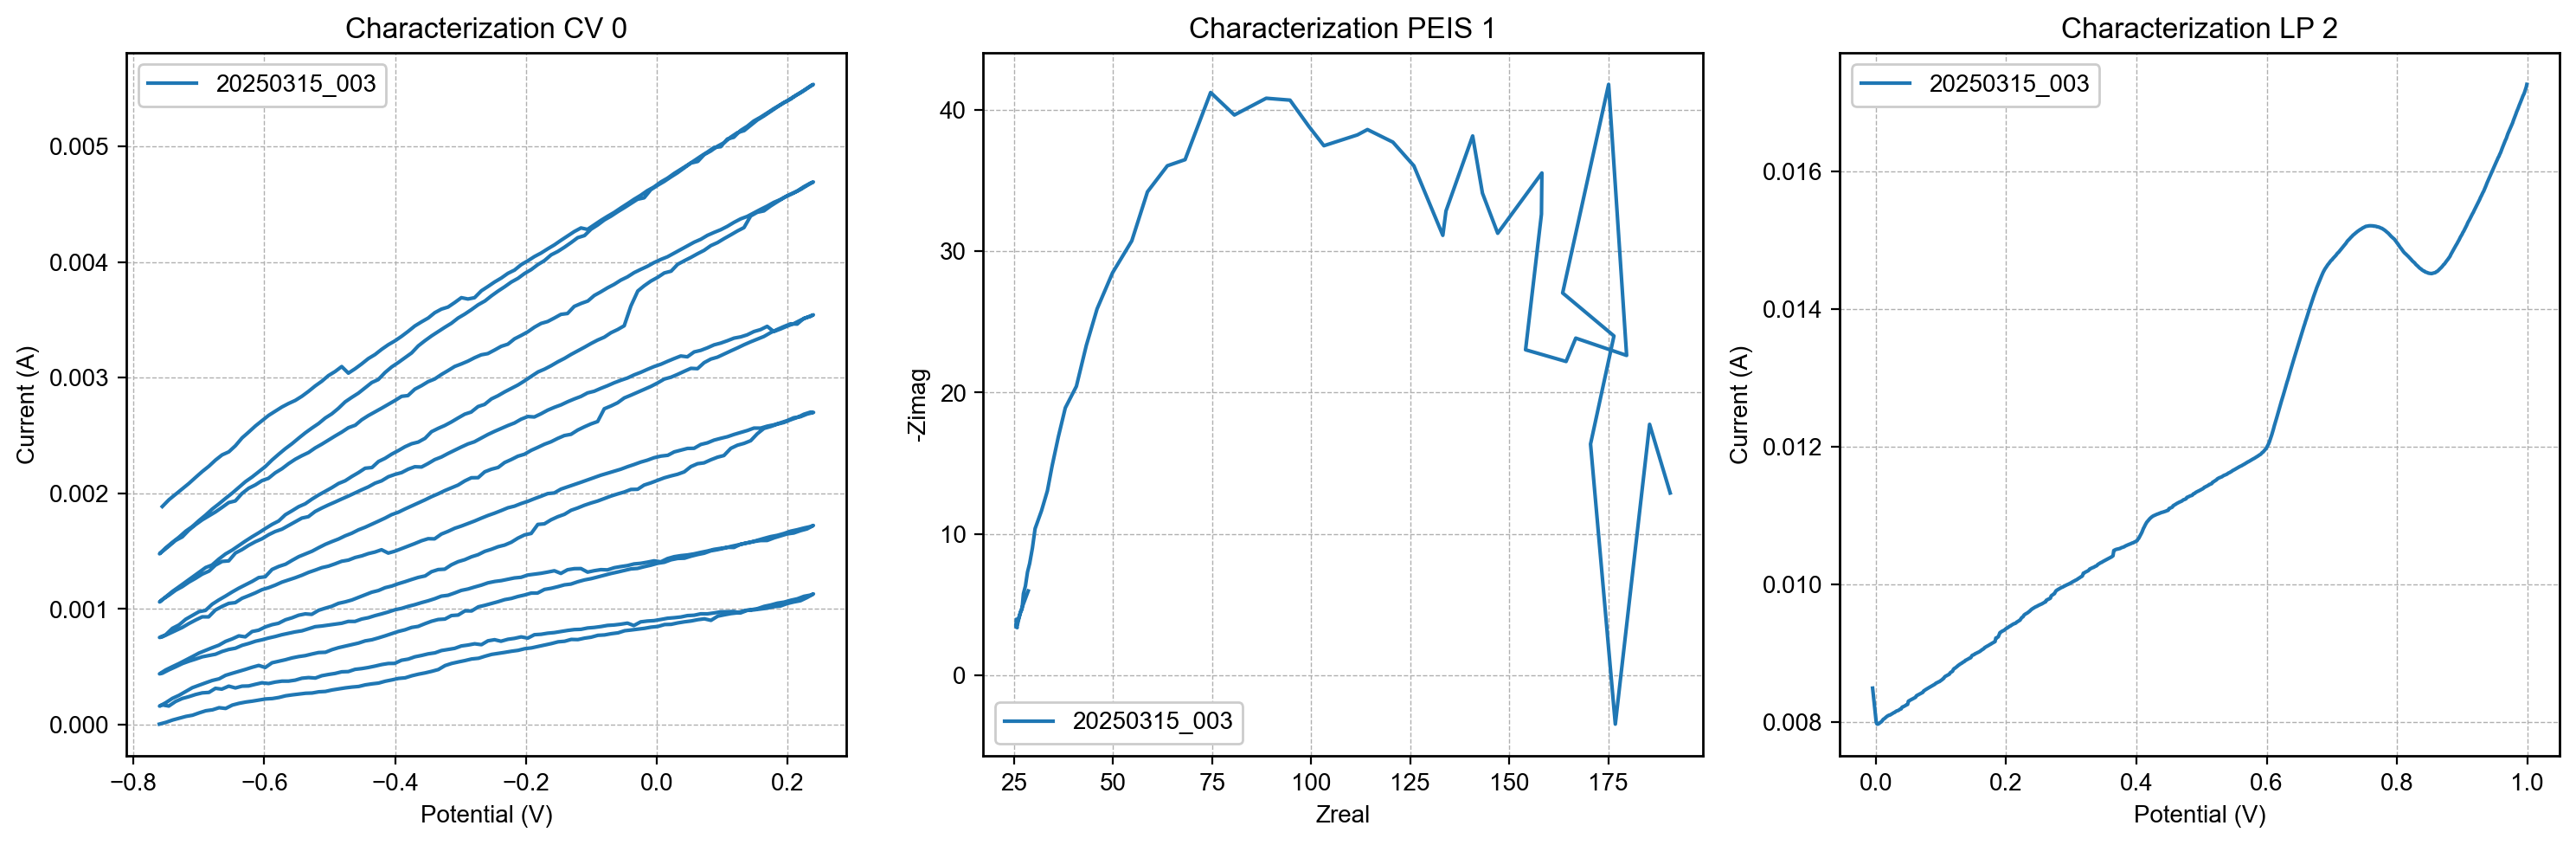

In [11]:
# Example usage: Saving individual plots
# plot_ocv(dep_ocv0, "Deposition OCV 0", "dep_ocv0.png", deposition_fig_folder, save=False)
# plot_cp(dep_cp1, "Deposition CP 1", "dep_cp1.png", deposition_fig_folder, save=False)
# plot_ocv(dep_ocv2, "Deposition OCV 2", "dep_ocv2.png", deposition_fig_folder, save=False)

# plot_cv(chara_cv0, "Characterization CV 0", "chara_cv0.png", characterization_fig_folder, save=False)
# plot_peis(chara_peis1, "Characterization PEIS 1", "chara_peis1.png", characterization_fig_folder, save=False)
# plot_lp(chara_lp2, "Characterization LP 2", "chara_lp2.png", characterization_fig_folder, save=False)
# plot_lp(chara_lp3, "Characterization LP 3", "chara_lp3.png", characterization_fig_folder, save=False)

# Example usage: Combining Deposition & Characterization data
plot_combined_deposition(dep_ocv0, dep_cp1, dep_ocv2, "Deposition Combined", "dep_combined.png", deposition_fig_folder, save=False)
plot_combined_characterization(chara_cv0, chara_peis1, chara_lp3, "Characterization Combined", "chara_combined.png", characterization_fig_folder, save=False)

### Functions to process data

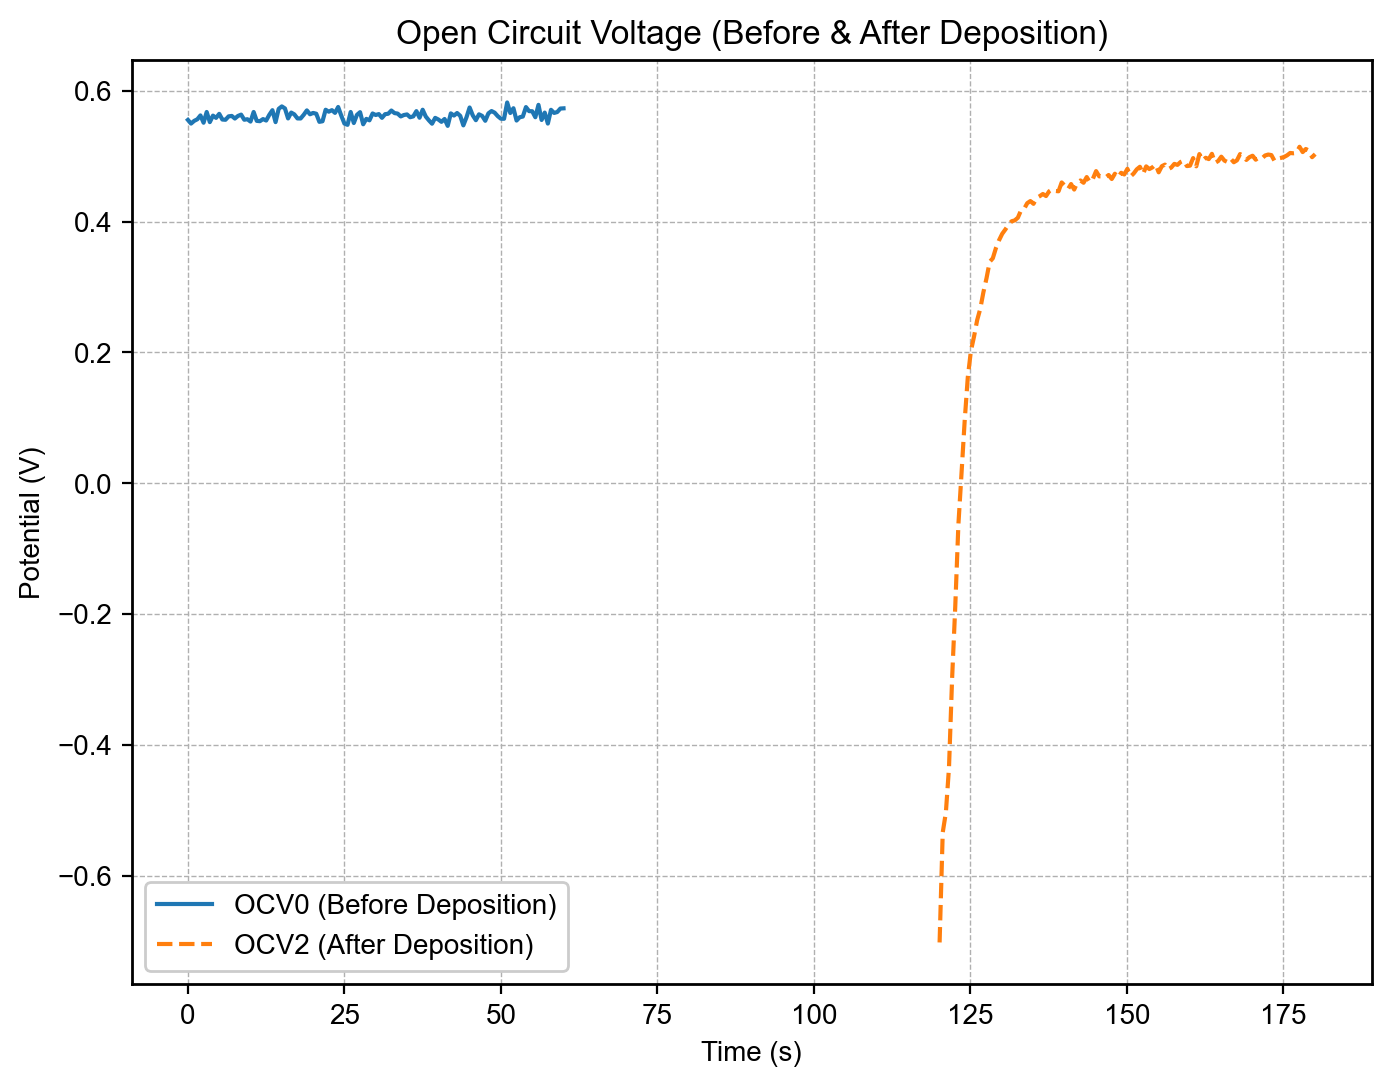

,OCV_Substrate (V),OCV_Materials (V),OCV_Difference (V)
0,0.573329,0.503296,-0.070033


In [36]:
# process the ocv data
def process_ocv(ocv0, ocv2, plot = False, filename="processed_ocv.png", folder=deposition_fig_folder,save=False):
    ocv_initial = ocv0['Ewe'].iloc[-1]  # get the last point
    ocv_final = ocv2['Ewe'].iloc[-1]  # get the last point
    ocv_difference = ocv_final - ocv_initial
    
    ocv_results = pd.DataFrame({
        "OCV_Substrate (V)": [ocv_initial],
        "OCV_Materials (V)": [ocv_final],
        "OCV_Difference (V)": [ocv_difference]
    })

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ocv0['total_time'], ocv0['Ewe'], label="OCV0 (Before Deposition)")
        ax.plot(ocv2['total_time'], ocv2['Ewe'], label="OCV2 (After Deposition)", linestyle="dashed")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Potential (V)")
        ax.legend()
        ax.set_title("Open Circuit Voltage (Before & After Deposition)")

        save_plot(fig, filename, folder, save)  # Save if option is enabled
        plt.show()

    return ocv_results

process_ocv(dep_ocv0, dep_ocv2,plot=True)  


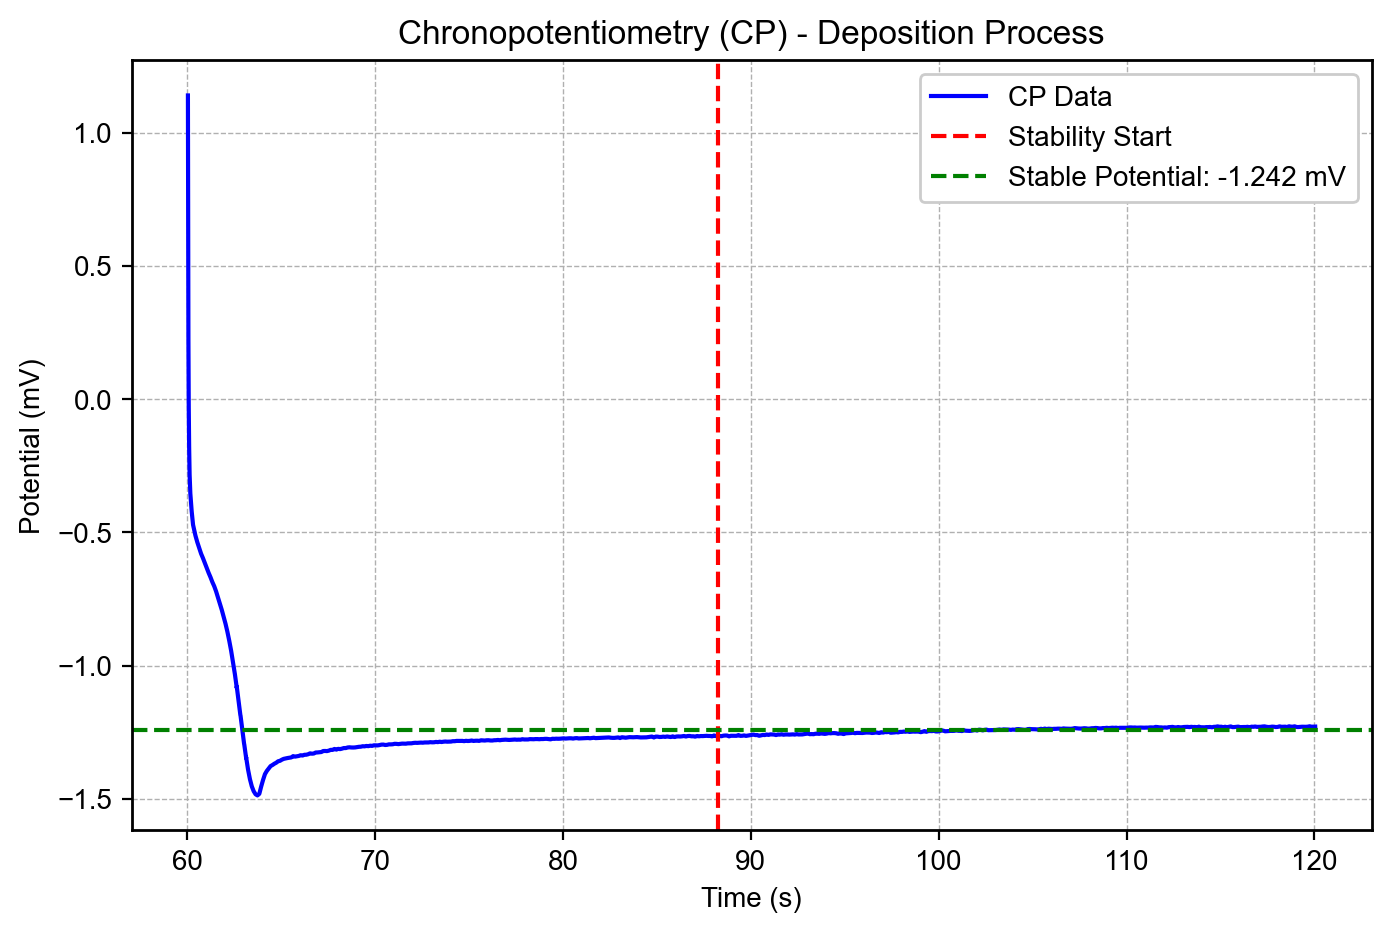

,Avg_Potential (V),Total_Charge (C),Stable_Potential (V)
0,-0.001162,-0.073629,-0.001242


In [37]:
def process_cp(cp_data, stability_fraction=0.5, plot=False, filename="processed_cp.png", folder=deposition_fig_folder, save=False):
    """
    Processes chronopotentiometry (CP) data with optional plotting and saving.

    Parameters:
        cp_data (DataFrame): CP data with columns ['total_time', 'Ewe', 'I'].
        stability_fraction (float): Fraction of data considered stable.
        plot (bool): Whether to generate a plot.
        save (bool): Whether to save the plot.
        filename (str): Name of the file to save the plot.
        folder (str): Directory to save the plot.

    Returns:
        DataFrame: Containing average potential, total charge, and stable potential.
    """
    avg_potential = cp_data['Ewe'].mean()  # Average potential
    total_charge = cp_data['I'].sum() * (cp_data['total_time'].iloc[-1] - cp_data['total_time'].iloc[0]) / 1000       #  ∫ I dt = Q

    stability_index = int(len(cp_data) * (1 - stability_fraction))
    stable_potential = cp_data['Ewe'].iloc[stability_index:].mean()

    # Create a DataFrame for structured output
    cp_results = pd.DataFrame({
        "Avg_Potential (V)": [avg_potential/1000],
        "Total_Charge (C)": [total_charge],
        "Stable_Potential (V)": [stable_potential/1000]
    })

    if plot:
        fig, ax = plt.subplots(figsize=(8,5))
        ax.plot(cp_data['total_time'], cp_data['Ewe'], label="CP Data", color="blue")

        # Stability stage
        ax.axvline(cp_data['total_time'].iloc[stability_index], color="red", linestyle="--", label="Stability Start")
        ax.axhline(stable_potential, color="green", linestyle="--", label=f"Stable Potential: {stable_potential:.3f} mV")

        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Potential (mV)")
        ax.set_title("Chronopotentiometry (CP) - Deposition Process")
        ax.legend()

        save_plot(fig, filename, folder, save)  # Save if option is enabled
        plt.show()

    return cp_results

process_cp(dep_cp1, plot=True)

Refining Initial Guess:   0%|          | 0/1 [00:00<?, ?it/s]

Running Bayesian Inference:   0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 1400x1200 with 0 Axes>

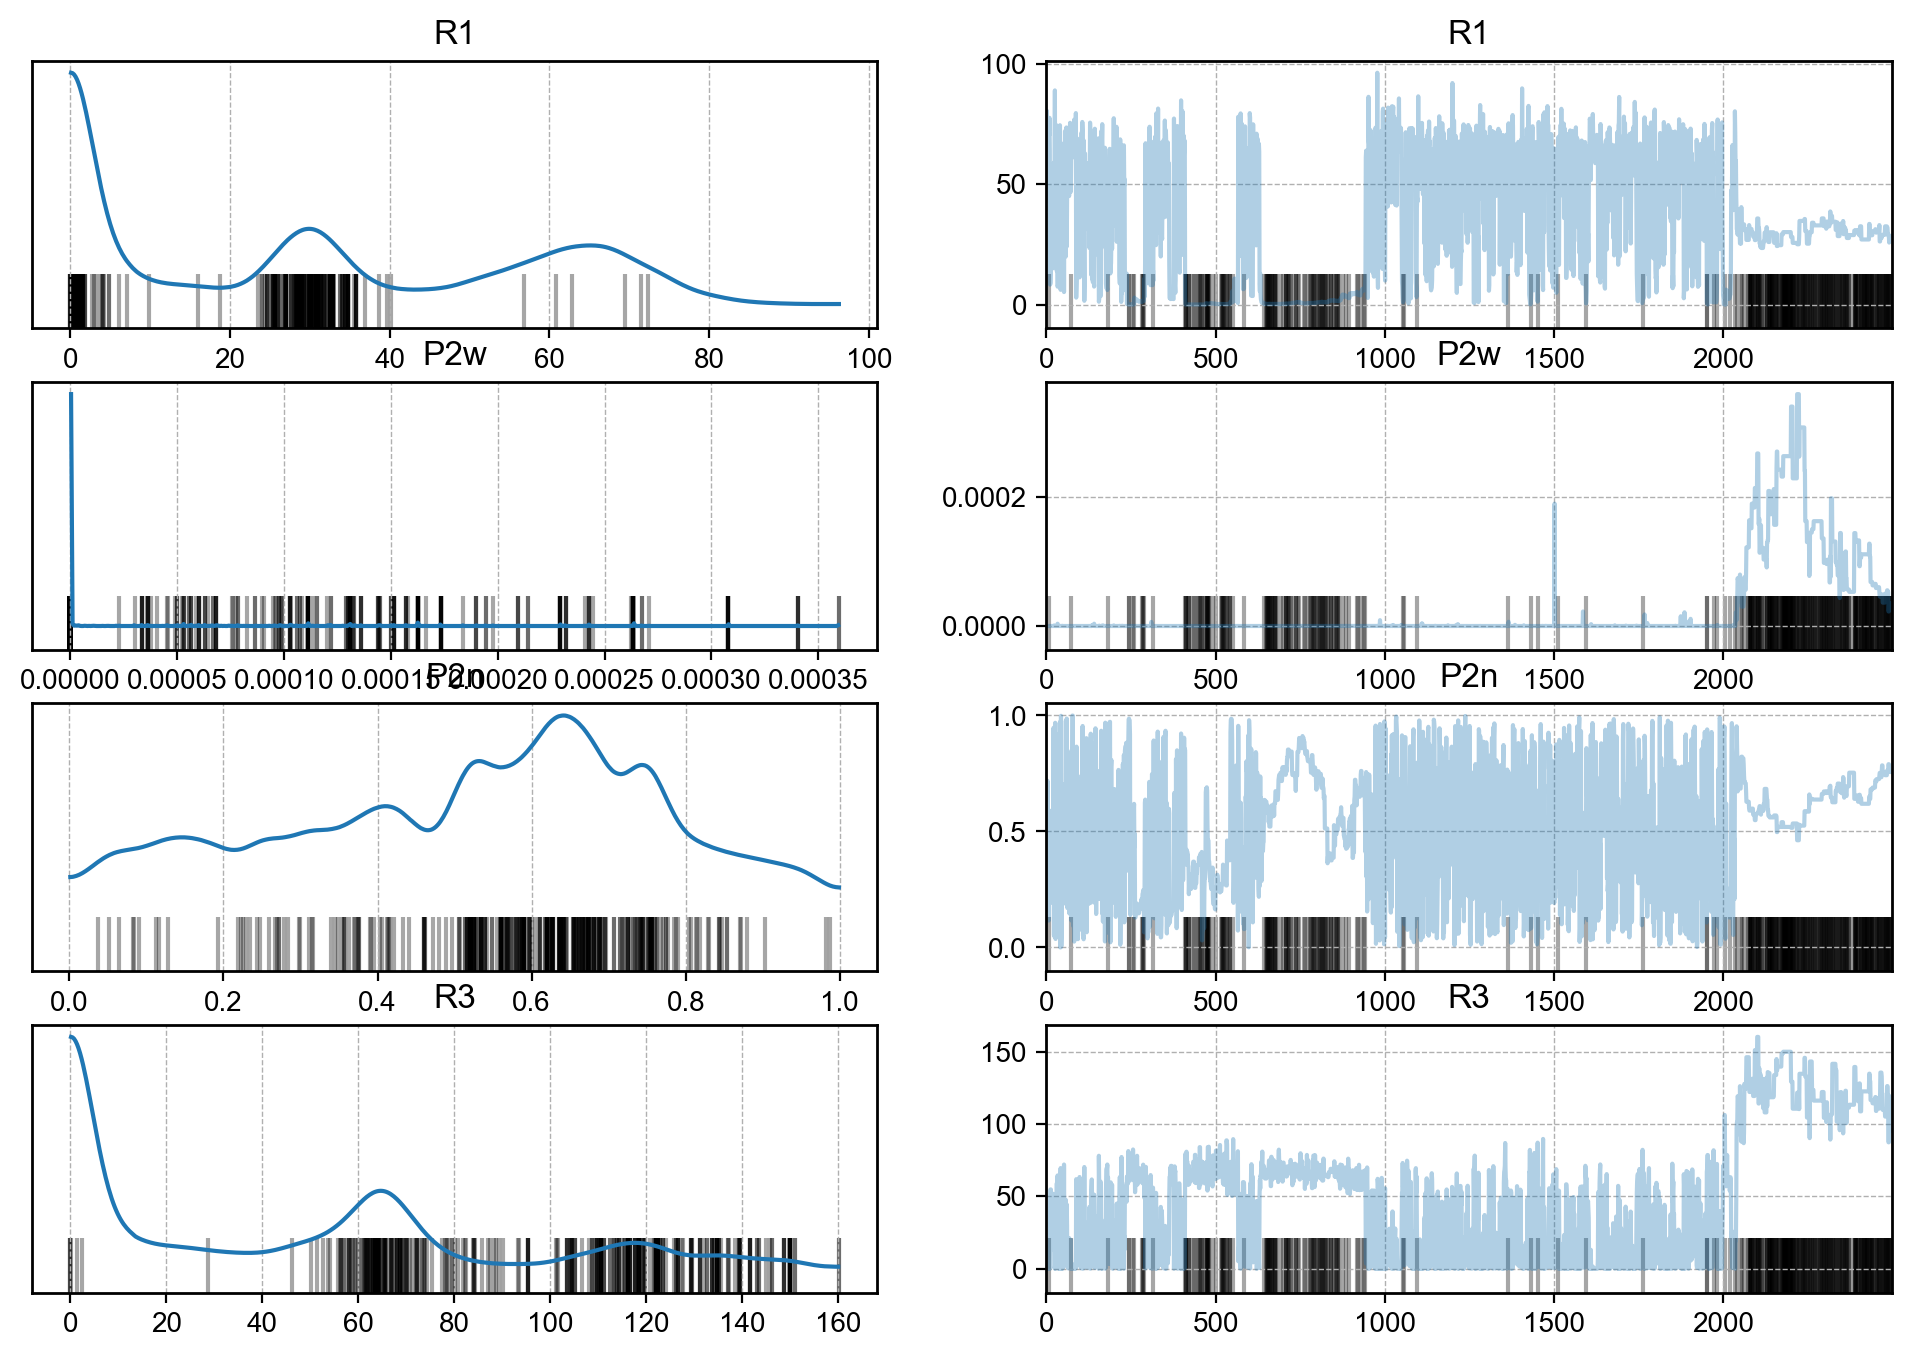

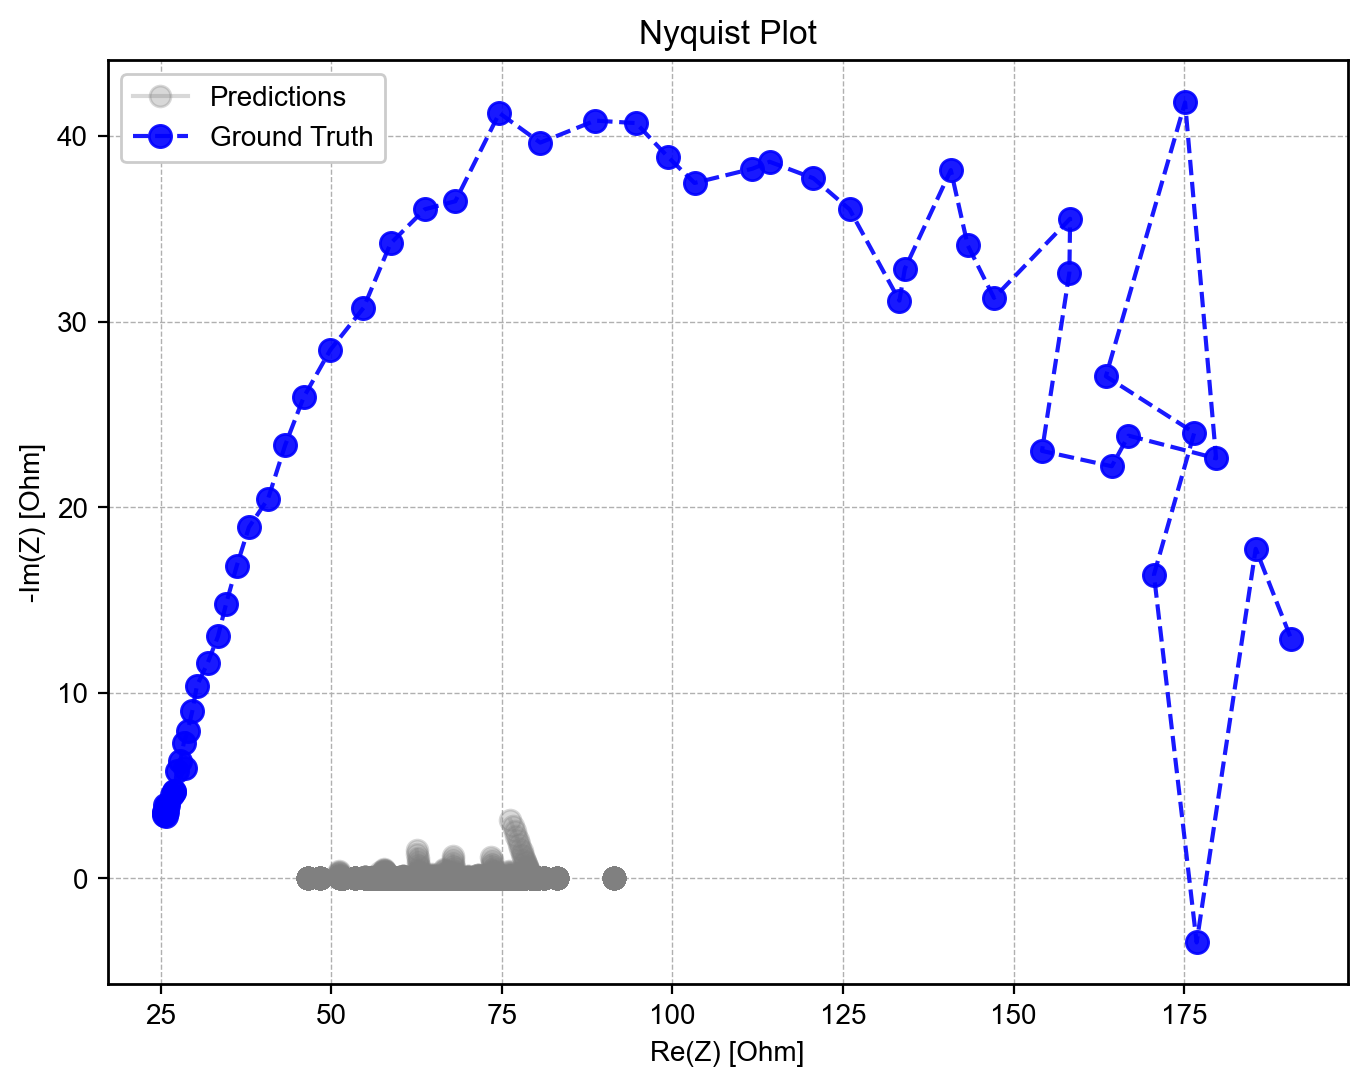

,Rs_mean,Rs_std,Cdl-Q_mean,Cdl-Q_std,Cdl-alpha_mean,Cdl-alpha_std,Rct_mean,Rct_std
0,33.90322457473637,26.11964001325233,2.582030567573576e-05,6.399082882630555e-05,0.5166967941491943,0.2529471247482699,49.403216588177926,43.779246589358635


In [ ]:
def process_peis(peis_data, plot=False, filename="processed_peis.png", folder=characterization_fig_folder, save=False):
    """
    Process PEIS data:
    1. Convert the data to impedance modulus and phase.
    2. Extract the Rs from the Nyquist plot.
    3. Extract the Rct from the Bode plot.
    4. Generate Nyquist and Bode plots that indicate the Rs and Rct values.
    5. apply autoeis to automatedly analyze the data
    6. plot the posterior distribution, and posterior predictions
    7. record the r2 value 
    8. record the results into a dataframe
    """
    def impedance_convert(data):
        data['Zmodulus'] = data['Ewe'] / data['I']
        data['Zreal'] = np.cos(data['phase_Zwe']) * data['Zmodulus']
        data['Zimag'] = np.sin(data['phase_Zwe']) * data['Zmodulus']
        return data

    converted_EIS_data = impedance_convert(peis_data)
    Z = converted_EIS_data['Zreal'] - 1j * converted_EIS_data['Zimag']
    freq = converted_EIS_data['freq']
    
    # get non-Nan values
    Z_nn_idx = ~Z.isna()
    Z_nn = Z[Z_nn_idx].values

    # get the frequency values
    freq_nn_idx = ~freq.isna()
    freq_nn = freq[freq_nn_idx].values
    
    # specify the circuit to be tested
    test_circuit = 'R1-[P2,R3]'

    
    # fit the circuit
    test_parameters = ae.utils.fit_circuit_parameters(test_circuit,freq_nn,Z_nn,method='bode')

    # perform Bayesian inference
    BI_results = ae.perform_bayesian_inference(test_circuit,freq_nn,Z_nn, p0=test_parameters,num_samples=2500,method='bode')

    # visualize the posterior distributions
    posterior_mcmc = az.convert_to_inference_data(BI_results[0].mcmc)
   
    if plot or save:
        # Create figure using matplotlib context
        plt.figure(figsize=(14, 12))
    
        # Generate trace plot using ArviZ
        axes = az.plot_trace(posterior_mcmc,var_names=['R1','P2w','P2n','R3'])
        fig = plt.gcf()  # Get current figure
    
        # Save figure if required
        if save:
            fig.savefig(os.path.join(folder, 'posterior_distributions.png'),
                   bbox_inches='tight', dpi=300)
    
        # Display plot if requested
        if plot:
            plt.show()
        else:
            plt.close(fig)  

    # Obtaining MCMC samples
    samples = BI_results[0].mcmc.get_samples()
    variables = ae.parser.get_parameter_labels(test_circuit)
    
    # Extracting all parameter sets for each sample
    param_sets = np.array([[samples[v][i] for v in variables] for i in range(len(samples[variables[0]]))])
    
    # Generating the circuit function
    circuit_fn = ae.utils.generate_circuit_fn(test_circuit)
    
    # Simulating impedance data for all samples
    Zsim_list = [circuit_fn(freq_nn, params) for params in param_sets]

    # Creating the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plotting each simulated impedance curve from the samples with transparency for clarity
    for Zsim in Zsim_list[:200]:
        ax.plot(Zsim.real, -Zsim.imag, "-", color='grey', alpha=0.3, label='Predictions' if Zsim is Zsim_list[0] else "", marker='.', ms=15)
    
    # Plotting the measured data (ground truth) using the specified styles
    ax.plot(Z_nn.real, Z_nn.imag, '--', marker='o', color='blue', alpha=0.9, ms=8, label='Ground Truth')

    # Customizing plot appearance
    ax.set_xlabel('Re(Z) [Ohm]')
    ax.set_ylabel('-Im(Z) [Ohm]')
    ax.set_title('Nyquist Plot')
    ax.grid(True)
    ax.legend()
    if save:
        plt.savefig(os.path.join(folder,'posterior_predictions.png'), dpi=300, bbox_inches='tight')
    # Closing the figure to prevent it from showing prematurely
    plt.show()
    plt.close(fig)

    # store the parameters 
    results = pd.DataFrame({
        "Rs_mean": [np.array(posterior_mcmc.posterior['R1'].mean())],
        "Rs_std": [np.array(posterior_mcmc.posterior['R1'].std())],
        "Cdl-Q_mean": [np.array(posterior_mcmc.posterior['P2w'].mean())],
        "Cdl-Q_std": [np.array(posterior_mcmc.posterior['P2w'].std())],
        "Cdl-alpha_mean": [np.array(posterior_mcmc.posterior['P2n'].mean())],
        "Cdl-alpha_std": [np.array(posterior_mcmc.posterior['P2n'].std())],
        "Rct_mean": [np.array((posterior_mcmc.posterior['R3'].mean()))],
        "Rct_std": [np.array(posterior_mcmc.posterior['R3'].std())],
    })
    return results

process_peis(chara_peis1, plot=True)

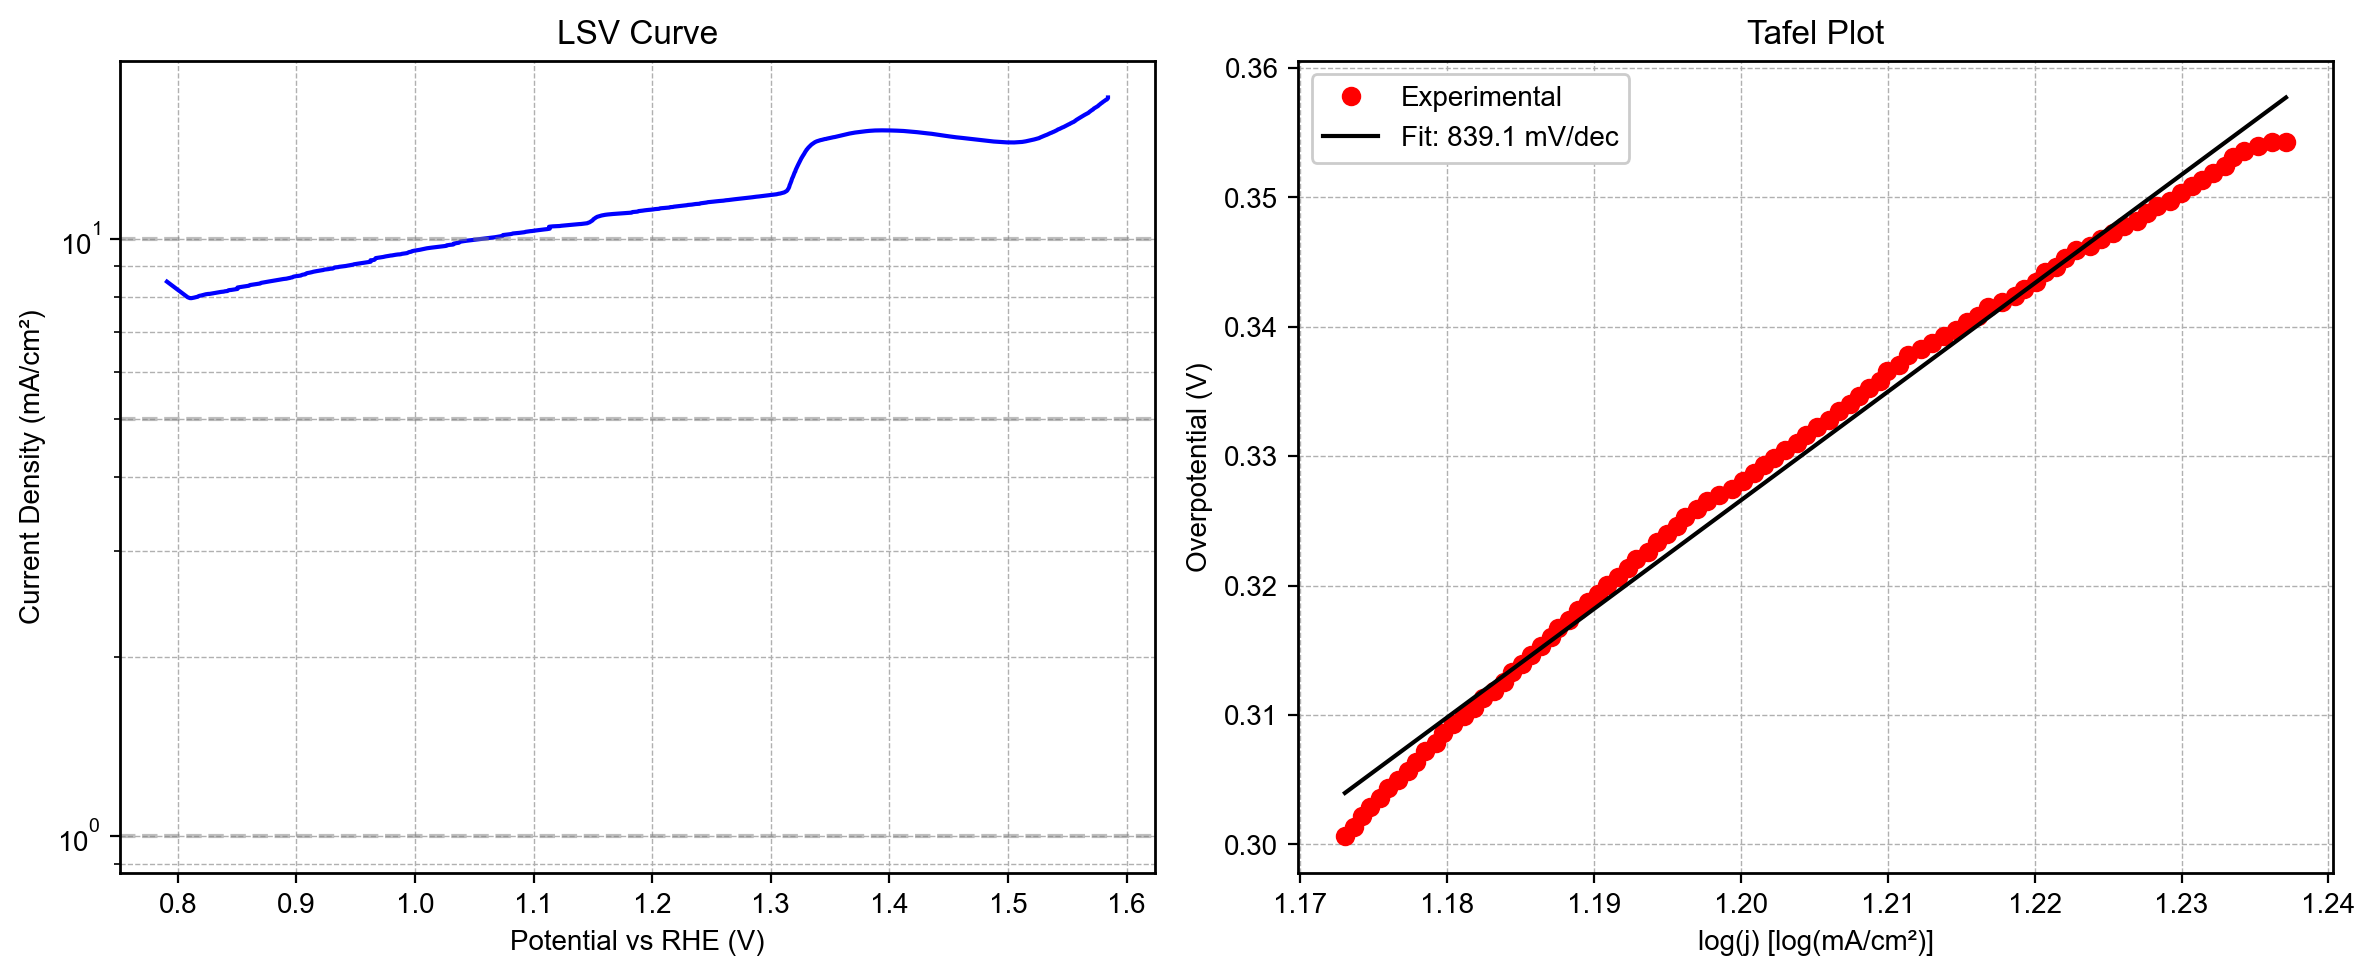

,pH,electrode_area,op_1mA,op_5mA,op_10mA,slope_mVdec,j0_mA_cm2,tafel_r2
0,13.6,1.0,-1.116145,-0.75447,-0.174611,839.141892,6.468548,0.991866


In [15]:
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score


def process_lsv(lsv_df, pH, R_solution=None, electrode_area=1.0, E_Ref = 1.23, plot=False, filename="processed_lp.png", folder=characterization_fig_folder, save=False):
    """
    Process LSV data:
    1. Converts potential to RHE scale.
    2. Extracts overpotential at 1, 5, 10 mA/cm².
    3. Calculates Tafel slope dynamically in the OER region.
    4. Generates LSV and Tafel plots.

    Parameters:
        lsv_df (DataFrame): LSV data with columns ["E_AgAgCl", "I_avg"].
        pH (float): pH of the electrolyte.
        electrode_area (float): Electrode geometric area (cm²).
        plot_results (bool): Whether to generate plots.

    Returns:
        dict: Overpotentials and Tafel parameters.
    """
    
    # Convert current to current density (mA/cm²)
    lsv_df["j_A_cm2"] = lsv_df["I_avg"] / electrode_area
    lsv_df["j_mA_cm2"] = lsv_df["j_A_cm2"] * 1000  # mA/cm²

    # Convert potential to RHE scale
    E_ref_AgAgCl = 0.197  # Reference potential for Ag/AgCl (1M KCl)
    lsv_df["E_RHE"] = lsv_df["Ewe_avg"] + E_ref_AgAgCl + 0.059 * pH

    # IR correction (if applicable)
    if R_solution is not None:
        lsv_df["E_RHE"] -= lsv_df["I_avg"] * R_solution 
    lsv_df["eta"] = lsv_df["E_RHE"] - E_Ref  # Overpotential (for OER)

    # Extract overpotential at specific current densities
    def get_overpotential(j_target):
        sorted_df = lsv_df
        j_values = sorted_df["j_mA_cm2"].values
        eta_values = sorted_df["eta"].values

        # find the first index that is higher than the target current density
        idx_above = np.argmax(j_values > j_target)
        idx_below = idx_above - 1

        j_below = j_values[idx_below]
        j_above = j_values[idx_above]

        eta_below = eta_values[idx_below]
        eta_above = eta_values[idx_above]

        eta_target = eta_below + (j_target - j_below) * (eta_above - eta_below) / (j_above - j_below)
        return float(eta_target)

    eta_values = {
        "op_1mA": get_overpotential(1),
        "op_5mA": get_overpotential(5),
        "op_10mA": get_overpotential(10)
    }

    # Tafel slope calculation (OER region)
    tafel_data = {
        "slope_mVdec": None,
        "j0_mA_cm2": None,
        "tafel_r2": None
    }
    tafel_region = (lsv_df["eta"].between(0.3, 0.5))

    if tafel_region.sum() < 4:  # Require minimum 4 points for fitting
        print("Insufficient data points for Tafel analysis.")
    else:
        df_tafel = lsv_df[tafel_region].copy()
        x = np.log10(df_tafel["j_mA_cm2"])
        y = df_tafel["eta"]
        
        try:
            coeffs = np.polyfit(x, y, 1)
            slope = coeffs[0] * 1000  # Convert to mV/dec
            j0 = 10**(-coeffs[1]/coeffs[0])
            r2 = r2_score(y, np.polyval(coeffs, x))
            
            tafel_data.update({
                'slope_mVdec': slope,
                'j0_mA_cm2': j0,
                'tafel_r2': r2
            })
        except Exception as e:
            print(f"Tafel analysis failed: {str(e)}")
    
    # Create a DataFrame for structured output
    results_df = pd.DataFrame({
        "pH": [pH],
        "electrode_area": [electrode_area],
        **{k: [v] for k, v in eta_values.items()},
        **{k: [v] for k, v in tafel_data.items()}
    })

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        # LSV plot
        axs[0].semilogy(lsv_df["E_RHE"], lsv_df["j_mA_cm2"], 'b-')
        for j in [1, 5, 10]:
            axs[0].axhline(j, color='gray', linestyle='--', alpha=0.5)

        axs[0].set_xlabel('Potential vs RHE (V)')
        axs[0].set_ylabel('Current Density (mA/cm²)')
        axs[0].set_title('LSV Curve')
        axs[0].grid(True, which='both')
        
        # Tafel plot
        if tafel_data['slope_mVdec'] is not None:
            axs[1].plot(x, y, 'ro', label='Experimental')
            axs[1].plot(x, np.polyval(coeffs, x), 'k-', 
                        label=f'Fit: {tafel_data["slope_mVdec"]:.1f} mV/dec')
            axs[1].set_xlabel('log(j) [log(mA/cm²)]')
            axs[1].set_ylabel('Overpotential (V)')
            axs[1].set_title('Tafel Plot')
            axs[1].legend()
            axs[1].grid(True)

        plt.tight_layout()

        save_plot(fig, filename, folder, save)  # Save if option is enabled
        plt.show()
    
    
    return results_df

process_lsv(chara_lp3, pH=13.6, R_solution=24, electrode_area=1.0, E_Ref = 1.23, plot=True)

### All-in-one analysis

In [294]:
# now assemble all the above function into a single function

def process_all_data(substrate_path, substrate_dict, substrate_id, pH=13.6, electrode_area=1.0, E_Ref = 1.23, IR_correction = False, save=False, plot=False):
    """
    Process all data for a given substrate ID.
    """

    # create deposition and characterization figure folders
    deposition_folder = substrate_path + f"/{substrate_dict[substrate_id]}" +"/deposition"
    characterization_folder = substrate_path + f"/{substrate_dict[substrate_id]}" +"/characterization"

    # Create figure directories if they don’t exist
    deposition_fig_folder = os.path.join(deposition_folder, "figures")
    characterization_fig_folder = os.path.join(characterization_folder, "figures")

    os.makedirs(deposition_fig_folder, exist_ok=True)
    os.makedirs(characterization_fig_folder, exist_ok=True)
    
    # Load deposition data
    dep_files = os.listdir(deposition_folder)
    charc_files = os.listdir(characterization_folder)

    # Filter files based on the measurement type and ensure they end with '.mpr'
    dep_ocv0_path = [f for f in dep_files if "_0_ocv" in f and f.endswith('.csv')]
    dep_cp1_path = [f for f in dep_files if "_1_cp" in f and f.endswith('.csv')]
    dep_ocv2_path = [f for f in dep_files if "_2_ocv" in f and f.endswith('.csv')]
    chara_cv0_path = [f for f in charc_files if "_0_cv" in f and f.endswith('.csv')]
    chara_peis1_path = [f for f in charc_files if "_1_peis" in f and f.endswith('.csv')]
    chara_lp2_path = [f for f in charc_files if "_2_lp" in f and f.endswith('.csv')]
    chara_lp3_path = [f for f in charc_files if "_3_lp" in f and f.endswith('.csv')]

    # Load data
    dep_ocv0 = pd.read_csv(deposition_folder + '/' + dep_ocv0_path[0])
    dep_cp1 = pd.read_csv(deposition_folder + '/' + dep_cp1_path[0])
    dep_ocv2 = pd.read_csv(deposition_folder + '/' + dep_ocv2_path[0])
    chara_cv0 = pd.read_csv(characterization_folder + '/' + chara_cv0_path[0])
    chara_peis1 = pd.read_csv(characterization_folder + '/' + chara_peis1_path[0])
    chara_lp2 = pd.read_csv(characterization_folder + '/' + chara_lp2_path[0])
    chara_lp3 = pd.read_csv(characterization_folder + '/' + chara_lp3_path[0])
    
    # visualize the deposition data
    if plot:
        plot_combined_deposition(dep_ocv0, dep_cp1, dep_ocv2, "Deposition Combined", "dep_combined.png", substrate_path + f"/{substrate_dict[substrate_id]}", label = substrate_id, save=save)

    # visualize the characterization data
    if plot:
        plot_combined_characterization(chara_cv0, chara_peis1, chara_lp3, "Characterization Combined", "chara_combined.png", substrate_path + f"/{substrate_dict[substrate_id]}", label = substrate_id,save=save)
        
    # Process OCV data
    ocv_results = process_ocv(dep_ocv0, dep_ocv2, plot=plot, filename="processed_ocv.png", folder=substrate_path + f"/{substrate_dict[substrate_id]}" , save=save)
    
    # Process CP data
    cp_results = process_cp(dep_cp1, plot=plot, filename="processed_cp.png", folder=substrate_path + f"/{substrate_dict[substrate_id]}", save=save)

    # Process PEIS data
    peis_results = process_peis(chara_peis1, plot=plot, filename="processed_peis.png", folder=substrate_path + f"/{substrate_dict[substrate_id]}", save=save)

    # Process LSV data
    if IR_correction:
        lsv_results = process_lsv(chara_lp3, R_solution= peis_results['Rs_mean'].values[0], pH=pH, electrode_area=electrode_area, E_Ref = E_Ref, plot=plot, filename="processed_lp.png", folder=substrate_path + f"/{substrate_dict[substrate_id]}", save=save)
    else:
        lsv_results = process_lsv(chara_lp3, pH=pH, electrode_area=electrode_area, E_Ref = E_Ref, plot=plot, filename="processed_lp.png", folder=substrate_path + f"/{substrate_dict[substrate_id]}", save=save)

    # Combine all results
    results = pd.concat([ocv_results, cp_results, peis_results, lsv_results], axis=1)

    # insert sample ID
    results.insert(0, 'Sample_ID', substrate_id)

    results.to_csv(substrate_path + f"/{substrate_dict[substrate_id]}" + "/results.csv", index=False)
    
    return results



### Analysis

In [ ]:
# input board

# set sample batch
substrate_path = "/home/runzezhang/Data/OT2/20250314_substrate test"
substrate_dict = {
    "MGL_front1": "20250312_000", "MGL_front2": "20250313_001", "MGL_front3": "20250314_002",
    "MGL_back1": "20250314_003", "MGL_back2": "20250314_004", "MGL_back3": "20250314_005",
    "398b_front1": "20250314_006", "398b_front2": "20250314_007", "398b_front3": "20250314_008",
    "398b_back1": "20250314_009", "398b_back2": "20250314_010", "398b_back3": "20250314_011",
    "590937_front1": "20250314_012", "590937_front2": "20250314_013", "590937_front3": "20250314_014"
}
substrate_id = "MGL_front1"


# set process parameters: pH, electrode_area, E_Ref, IR_correction, save, plot
pH = 13.6
electrode_area = 1.0
E_Ref = 1.23
IR_correction = True
save = True
plot = True

Refining Initial Guess:   0%|          | 0/1 [00:00<?, ?it/s]

Running Bayesian Inference:   0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 1400x1200 with 0 Axes>

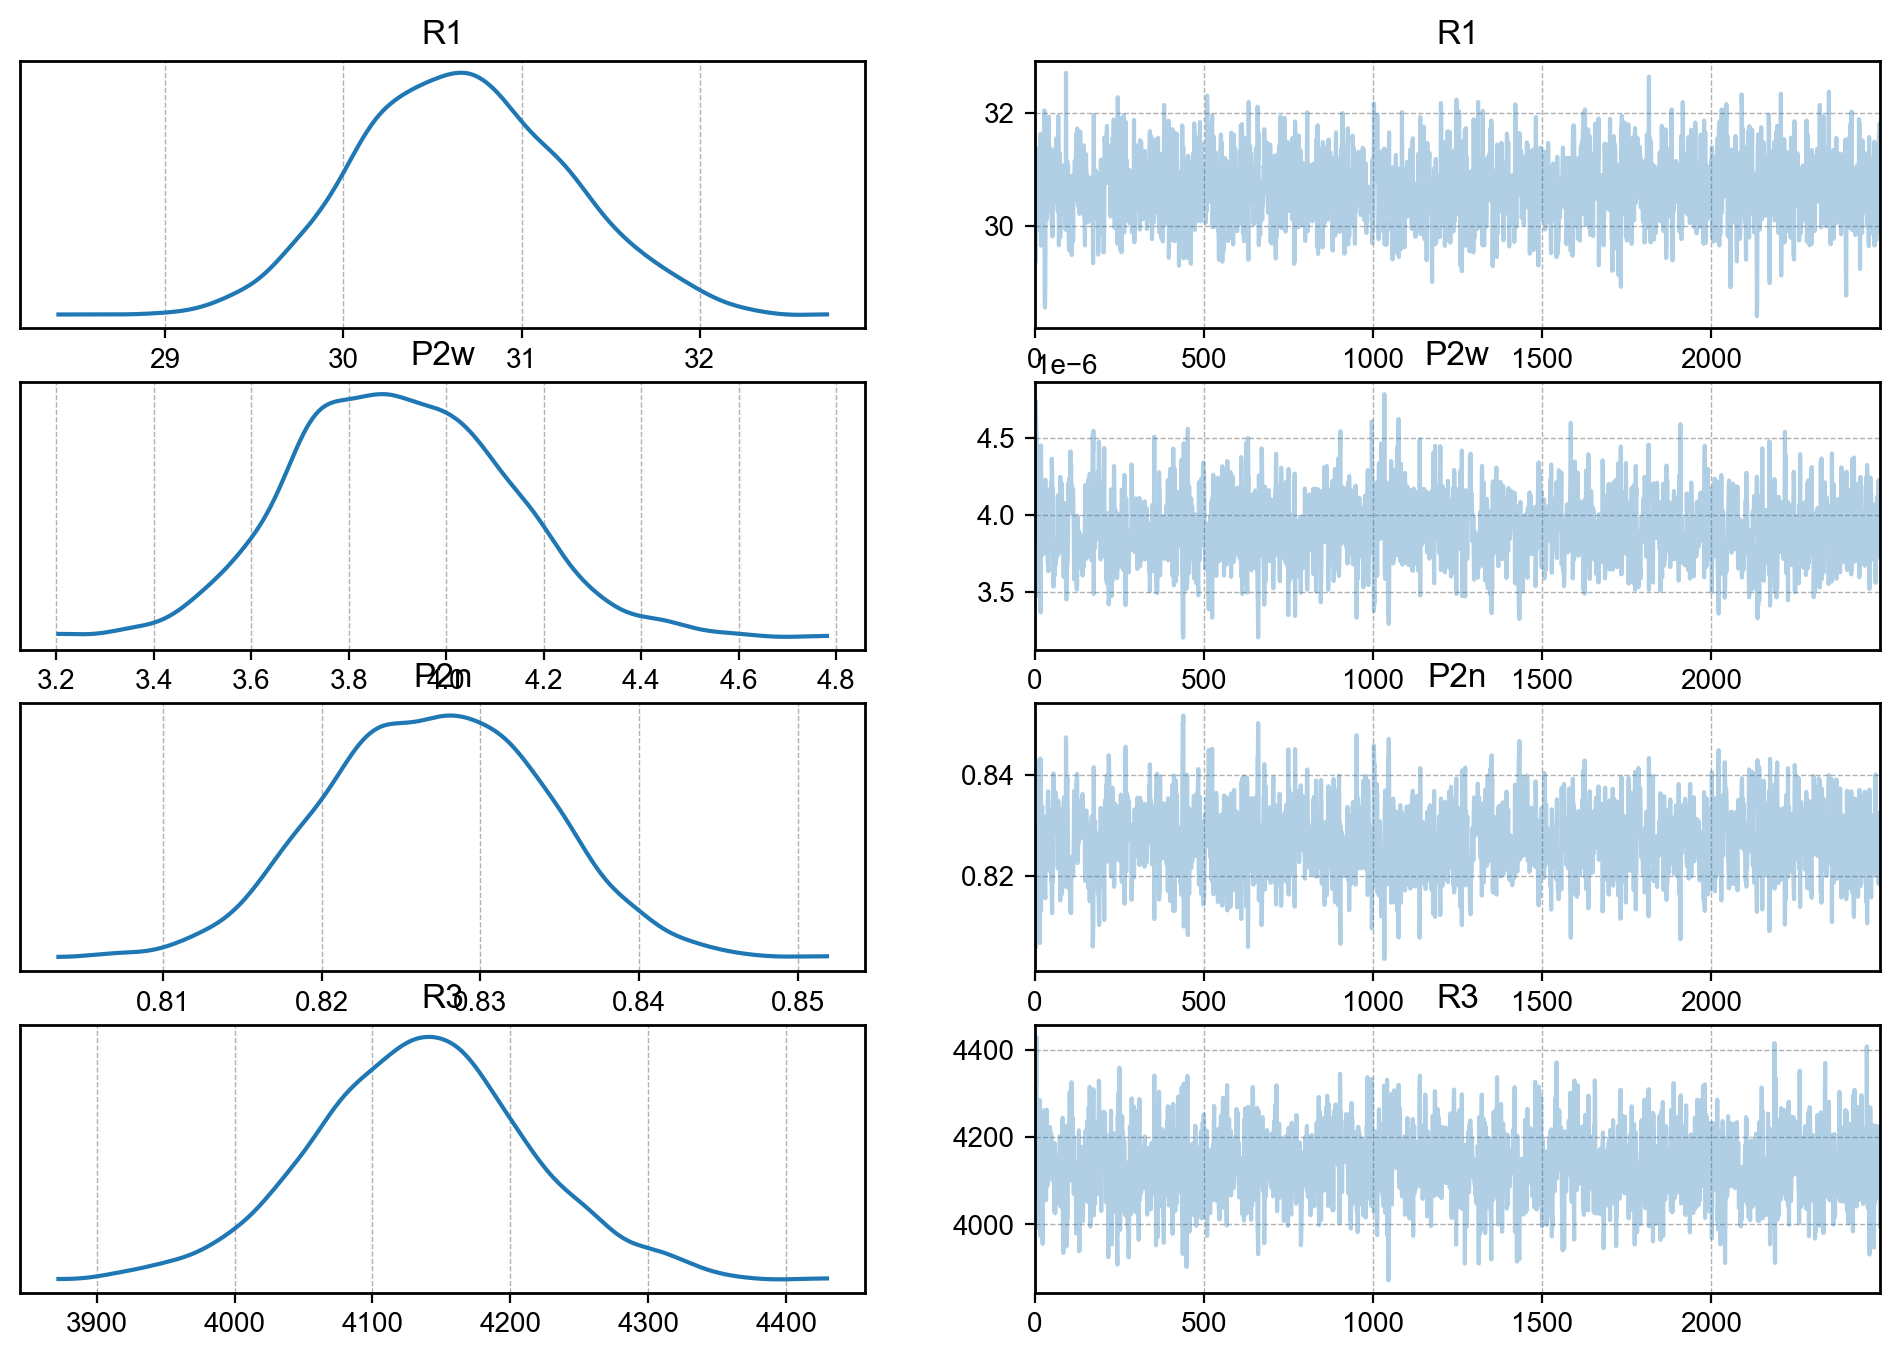

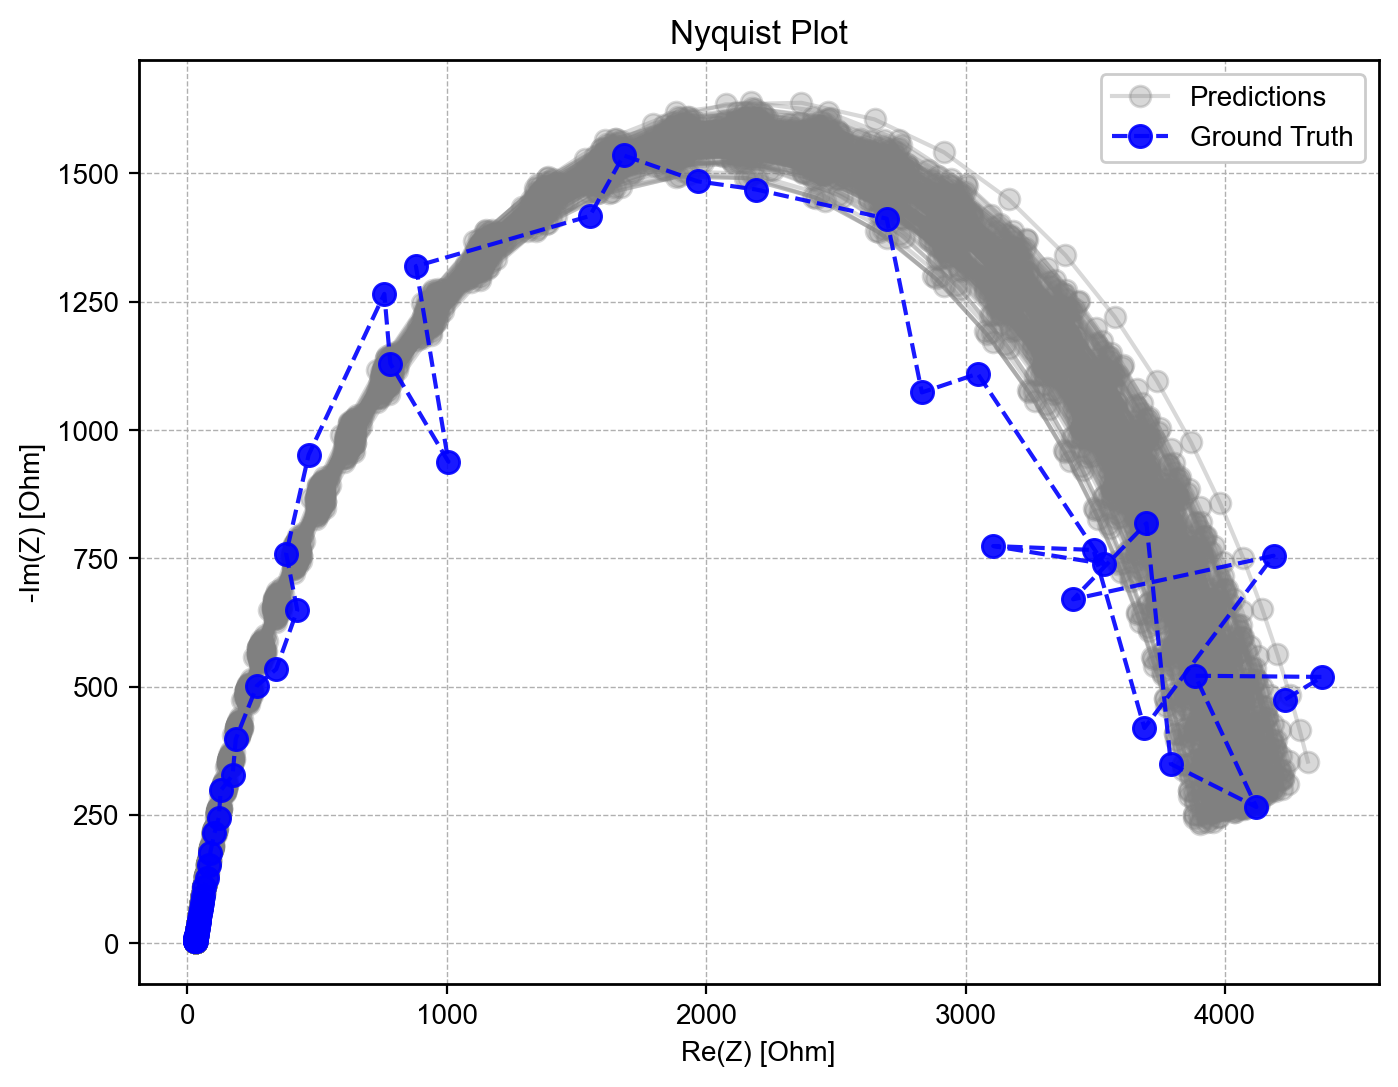

In [306]:
results = process_all_data(substrate_path, substrate_dict, substrate_id, pH, electrode_area, E_Ref, IR_correction, save, plot)

In [ ]:
results

,Sample_ID,OCV_Substrate (V),OCV_Materials (V),OCV_Difference (V),Avg_Potential (V),Total_Charge (C),Stable_Potential (V),Rs_mean,Rs_std,Cdl-Q_mean,...,Rct_mean,Rct_std,pH,electrode_area,op_1mA,op_5mA,op_10mA,slope_mVdec,j0_mA_cm2,tafel_r2
0,592057_back1,0.088696,-0.08155,-0.170246,-0.002073,-0.073067,-0.002218,24.304579863393226,1.2421229777604408,0.00010610171444755188,...,34020.9599090049,618765.1947893356,13.6,1.0,0.115551,0.348061,0.402703,174.401372,0.047706,0.976807
